In [ ]:
#Installing the libraries for splitting up the folders
!pip install split-folders -q

In [ ]:
!pip install tensorflow -q

In [ ]:
#Import the necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import splitfolders
import os
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
print("All libraries are installed and imported succesfully")

All libraries are installed and imported succesfully


In [ ]:
#Set up Kaggle API Key
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your 'kaggle.json' file.")
    uploaded = files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("APi key already exists.")

# Download and unzip the dataset if it doesn't exist
raw_data_dir = '/content/Citrus_Leaves_Raw'
if not os.path.exists(raw_data_dir):
    print("Downloading and unzipping the Citrus Leaf dataset...")
    !kaggle datasets download -d myprojectdictionary/citrus-leaf-disease-image -p /content
    !unzip -q /content/citrus-leaf-disease-image.zip -d {raw_data_dir}
    print("✅ Dataset is ready.")
else:
    print("Dataset already downloaded.")

Please upload your 'kaggle.json' file.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/myprojectdictionary/citrus-leaf-disease-image
License(s): unknown
  0% 0.00/41.3M [00:00<?, ?B/s]
100% 41.3M/41.3M [00:00<00:00, 896MB/s]
✅ Dataset is ready.


In [ ]:
#spilt data into train, val and test set folder
input_folder = '/content/Citrus_Leaves_Raw/Citrus Leaf Disease Image'
output_folder = '/content/Citrus_Leaves_Split'
if not os.path.exists(output_folder):
    print("Splitting data into train, val, and test sets...")
    splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))
    print("data splitting complete")
else:
    print("Data already split.")

Splitting data into train, val, and test sets...


Copying files: 607 files [00:00, 2537.69 files/s]

data splitting complete


In [ ]:
#Defining the directories and image parameters
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')
Image_height = 224
Image_width = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(Image_height, Image_width), batch_size=batch_size, class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    val_dir, target_size=(Image_height, Image_width), batch_size=batch_size, class_mode='categorical')

test_generator = train_datagen.flow_from_directory(
    test_dir, target_size=(Image_height, Image_width), batch_size=batch_size, class_mode='categorical')

print("Data generators are ready.")
print("Class Indices", test_generator.class_indices)

Found 423 images belonging to 5 classes.
Found 88 images belonging to 5 classes.
Found 96 images belonging to 5 classes.
Data generators are ready.
Class Indices {'Black spot': 0, 'Canker': 1, 'Greening': 2, 'Healthy': 3, 'Melanose': 4}


In [ ]:
def build_model(base_model_class, num_classes):
    """Helper function to build a model with a given base."""

    base_model = base_model_class(input_shape=(Image_height, Image_width, 3),
                                  include_top=False,
                                  weights='imagenet')

    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

print("Building MobileNetV2 model...")
model_mobilenet = build_model(MobileNetV2, train_generator.num_classes)
model_mobilenet.summary()

print("\nBuilding InceptionV3 model...")
model_inception = build_model(InceptionV3, train_generator.num_classes)
model_inception.summary()

print("\n Both models are built and compiled successfully.")

Building MobileNetV2 model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,574,853 (13.64 MB)

 Trainable params: 1,316,869 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Building InceptionV3 model...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)


 Both models are built and compiled successfully.


In [ ]:
import time

EPOCHS = 10

print("--- Training MobileNetV2 ---")
start_time_mobile = time.time()

history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

end_time_mobile = time.time()
training_time_mobile = end_time_mobile - start_time_mobile
print(f"✅ MobileNetV2 training complete in {training_time_mobile / 60:.2f} minutes.")

print("\n--- Training InceptionV3 ---")
start_time_inception = time.time()

history_inception = model_inception.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

end_time_inception = time.time()
training_time_inception = end_time_inception - start_time_inception
print(f"✅ InceptionV3 training complete in {training_time_inception / 60:.2f} minutes.")

--- Training MobileNetV2 ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4369 - loss: 1.8875 - val_accuracy: 0.7727 - val_loss: 0.5919
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8095 - loss: 0.4638 - val_accuracy: 0.7841 - val_loss: 0.5463
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9210 - loss: 0.2535 - val_accuracy: 0.8182 - val_loss: 0.4588
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9448 - loss: 0.1851 - val_accuracy: 0.8295 - val_loss: 0.4685
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9738 - loss: 0.1303 - val_accuracy: 0.8409 - val_loss: 0.4871
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9806 - loss: 0.1048 - val_accuracy: 0.8750 - val_loss: 0.4740
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9997 - loss: 0.0500 - val_accuracy: 0.8523 - val_loss: 0.4813
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9949 - loss: 0.0487 - val_accuracy: 0.7955 - val_loss:

--- Displaying and saving results for MobileNetV2 ---


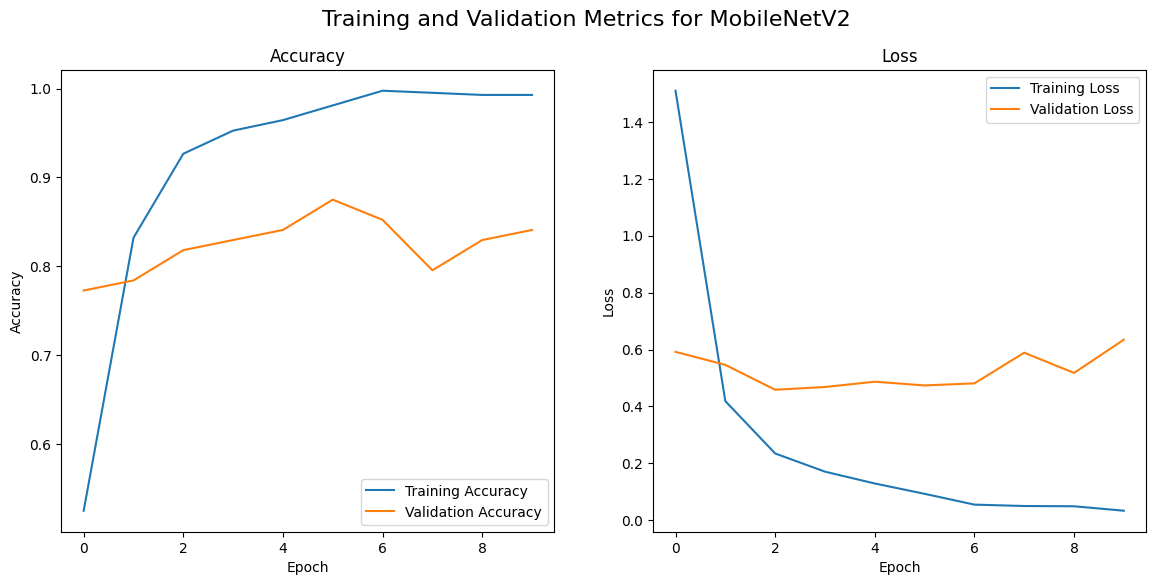


--- Displaying and saving results for InceptionV3 ---


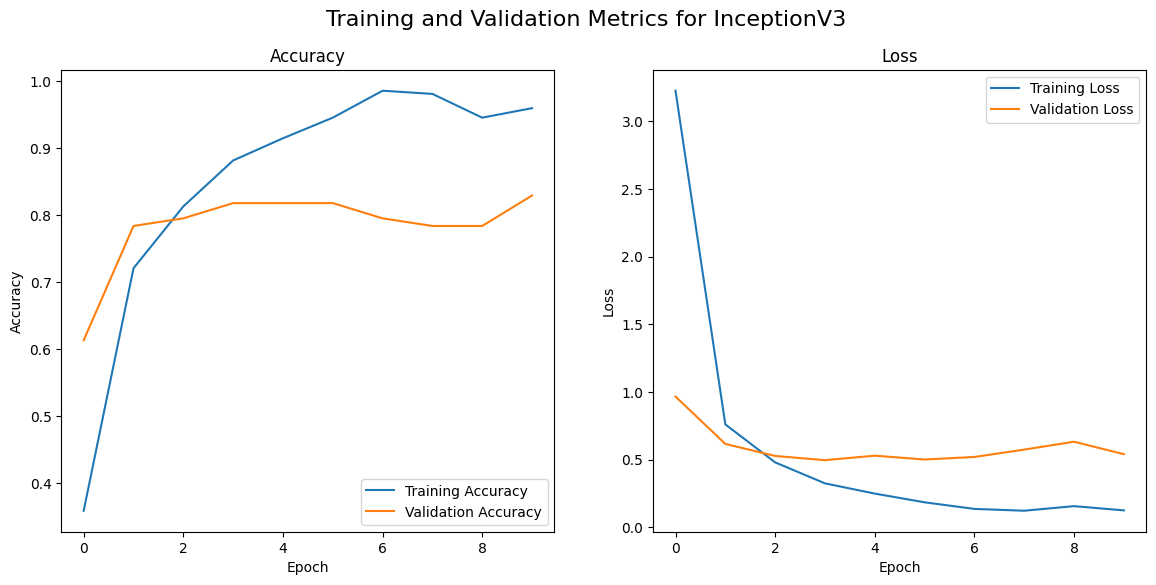


✅ Training plots have been generated and saved.


In [ ]:
import matplotlib.pyplot as plt

def plot_history_and_save(history, model_name, filename):
    """
    A helper function to plot the training and validation accuracy/loss
    and save the resulting figure to a file.
    """
    # Get the data from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    # Create a figure with two subplots, side-by-side
    plt.figure(figsize=(14, 6))
    plt.suptitle(f'Training and Validation Metrics for {model_name}', fontsize=16)

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Save the figure to the specified filename before showing it
    plt.savefig(filename)

    # Display the plot in the notebook
    plt.show()

# --- Plot and save results for both models ---
print("--- Displaying and saving results for MobileNetV2 ---")
plot_history_and_save(history_mobilenet, "MobileNetV2", "training_curve_mobilenet.png")

print("\n--- Displaying and saving results for InceptionV3 ---")
plot_history_and_save(history_inception, "InceptionV3", "training_curve_inception.png")

print("\n✅ Training plots have been generated and saved.")

In [ ]:
# import matplotlib.pyplot as plt

# def plot_history(history, model_name):
#     """A helper function to plot the training and validation accuracy and loss."""
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']

#     epochs_range = range(len(acc))

#     plt.figure(figsize=(14, 6))
#     plt.suptitle(f'Training and Validation Metrics for {model_name}', fontsize=16)

#     plt.subplot(1, 2, 1)
#     plt.plot(epochs_range, acc, label='Training Accuracy')
#     plt.plot(epochs_range, val_acc, label='Validation Accuracy')
#     plt.legend(loc='lower right')
#     plt.title('Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs_range, loss, label='Training Loss')
#     plt.plot(epochs_range, val_loss, label='Validation Loss')
#     plt.legend(loc='upper right')
#     plt.title('Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')

#     plt.show()

# # print("--- Displaying results for MobileNetV2 ---")
# # plot_history(history_mobilenet, "MobileNetV2")

# # print("\n--- Displaying results for InceptionV3 ---")
# # plot_history(history_inception, "InceptionV3")

# print("--- Displaying and saving results for MobileNetV2 ---")
# plot_history(history_mobilenet, "MobileNetV2", "training_curve_mobilenet.png")

# print("\n--- Displaying and saving results for InceptionV3 ---")
# plot_history(history_inception, "InceptionV3", "training_curve_inception.png")

# print("\n✅ Training plots have been generated and saved.")

--- Displaying and saving results for MobileNetV2 ---


TypeError: plot_history() takes 2 positional arguments but 3 were given

In [ ]:
print("--- Evaluating MobileNetV2 ---")
loss_mobile, acc_mobile = model_mobilenet.evaluate(test_generator)

print("\n--- Evaluating InceptionV3 ---")
loss_inception, acc_inception = model_inception.evaluate(test_generator)

model_mobilenet.save('mobilenet.keras')
model_inception.save('inceptionv3.keras')
size_mobile = os.path.getsize('mobilenet.keras') / (1024 * 1024) # in mb
size_inception = os.path.getsize('inceptionv3.keras') / (1024 * 1024) # in mb

print("\n\n--- Model Bake-Off Results ---")
print("=======================================================================")
print("| Metric                | MobileNetV2           | InceptionV3           |")
print("-----------------------------------------------------------------------")
print(f"| Test Accuracy         | {acc_mobile*100:.2f}%               | {acc_inception*100:.2f}%                |")
print(f"| Training Time (mins)  | {training_time_mobile/60:.2f}                 | {training_time_inception/60:.2f}                  |")
print(f"| Model Size (MB)       | {size_mobile:.2f}                  | {size_inception:.2f}                 |")
print("=======================================================================")

--- Evaluating MobileNetV2 ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8698 - loss: 0.6582

--- Evaluating InceptionV3 ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.7279 - loss: 0.7184


--- Model Bake-Off Results ---
| Metric                | MobileNetV2           | InceptionV3           |
-----------------------------------------------------------------------
| Test Accuracy         | 86.46%               | 72.92%                |
| Training Time (mins)  | 5.52                 | 12.55                  |
| Model Size (MB)       | 24.24                  | 108.29                 |


--- Performing Error Analysis for InceptionV3 ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step
Found 68 misclassified images.


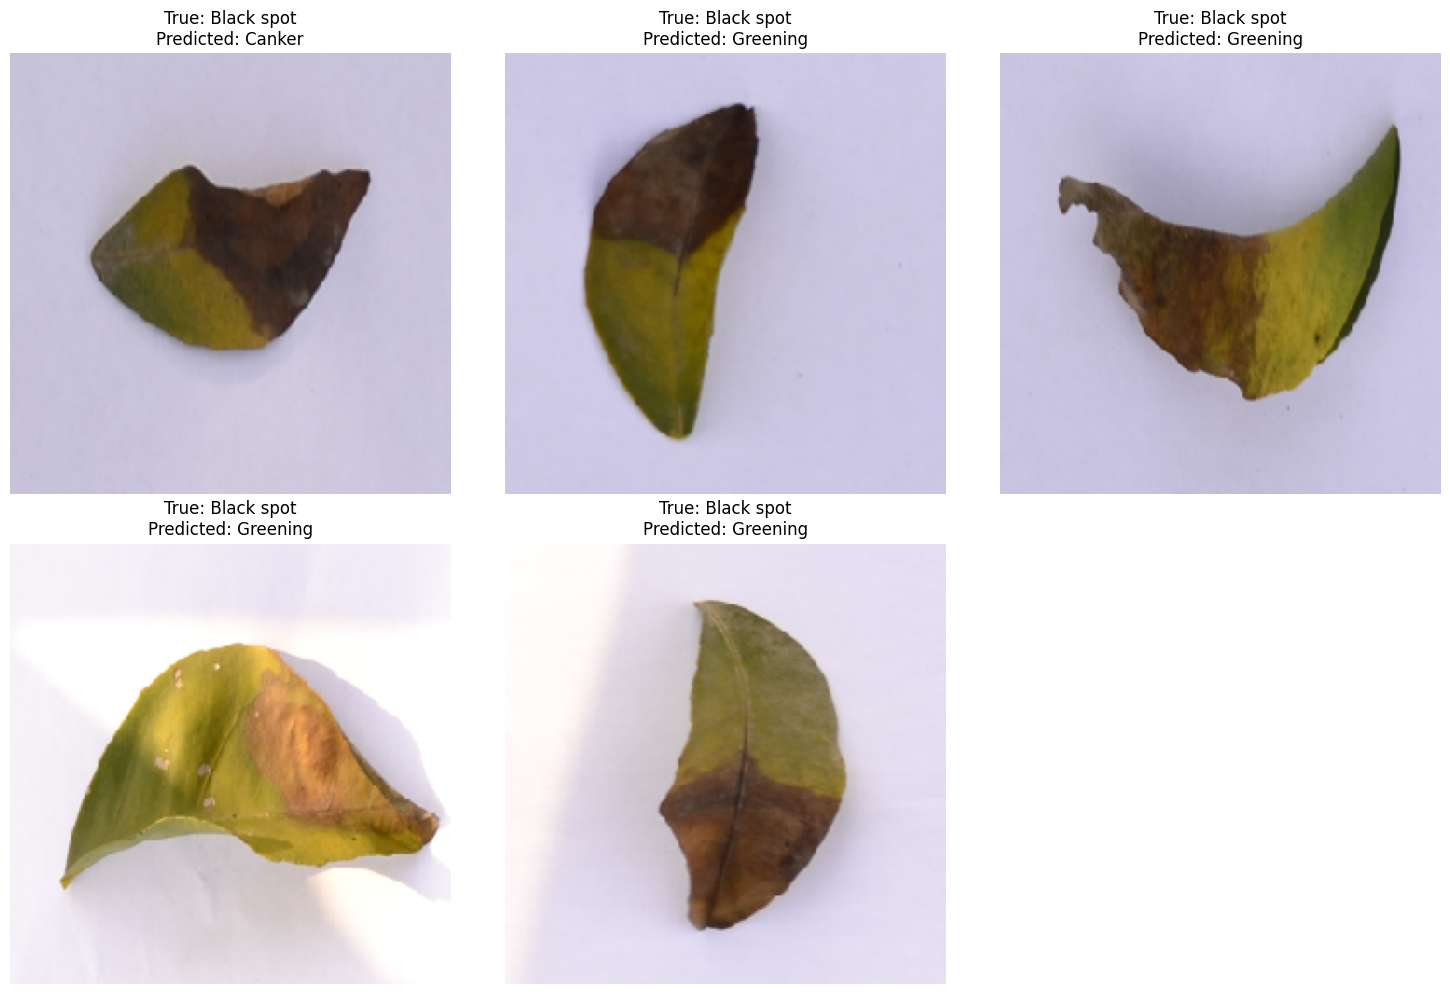

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
model_name = "InceptionV3"

print(f"--- Performing Error Analysis for {model_name} ---")

filenames = test_generator.filenames
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

Y_pred = model_inception.predict(test_generator)
predicted_labels = np.argmax(Y_pred, axis=1)

misclassified_indices = np.where(predicted_labels != true_labels)[0]
print(f"Found {len(misclassified_indices)} misclassified images.")

num_to_display = min(5, len(misclassified_indices))
if num_to_display > 0:
    plt.figure(figsize=(15, 5 * math.ceil(num_to_display/3)))
    for i, img_index in enumerate(misclassified_indices[:num_to_display]):
        img_path = os.path.join(test_dir, filenames[img_index])
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(Image_height, Image_width))
        plt.subplot(math.ceil(num_to_display/3), 3, i + 1)
        plt.imshow(img)
        true_label_name = class_names[true_labels[img_index]]
        predicted_label_name = class_names[predicted_labels[img_index]]
        plt.title(f"True: {true_label_name}\nPredicted: {predicted_label_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images found. The model is perfect on the test set!")

In [ ]:
# !pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.2 MB/s eta 0:00:00


In [ ]:
# import streamlit as st
# from PIL import Image
# import numpy as np
# import tensorflow as tf

# st.set_page_config(
#     page_title="CitriScan",
#     page_icon="🌿",
#     layout="wide"
# )

# @st.cache_resource
# def load_model():
#     """Loads the saved Keras model."""
#     try:
#         model = tf.keras.models.load_model('CitriScan_Best_Model_InceptionV3.keras')
#         return model
#     except Exception as e:
#         st.error(f"Error loading model: {e}")
#         return None

# model = load_model()

# CLASS_NAMES = ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']

# def preprocess_image(image):
#     """Preprocesses the uploaded image to fit the model's input requirements."""
#     img = image.resize((224, 224))
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     return img_array / 255.0

# st.title("CitriScan 🌿: Citrus Leaf Disease Detection")
# st.write(
#     "Upload an image of a citrus leaf to classify its health status. "
#     "This tool helps in the early detection of common citrus diseases, promoting sustainable farming."
# )

# st.sidebar.header("Upload Image")
# uploaded_file = st.sidebar.file_uploader(
#     "Choose a leaf image...", type=["jpg", "jpeg", "png"]
# )

# if uploaded_file is None:
#     st.info("Please upload an image using the sidebar to begin classification.")
# else:
#     col1, col2 = st.columns(2)

#     with col1:
#         st.subheader("Your Uploaded Image")
#         image = Image.open(uploaded_file)
#         st.image(image, use_column_width=True)

#     with col2:
#         st.subheader("Classification Result")
#         if st.button("Classify Leaf"):
#             with st.spinner('Analyzing the leaf...'):
#                 processed_image = preprocess_image(image)
#                 prediction = model.predict(processed_image)
#                 predicted_class_index = np.argmax(prediction)
#                 predicted_class_name = CLASS_NAMES[predicted_class_index]
#                 confidence = np.max(prediction) * 100

#                 if "Healthy" in predicted_class_name:
#                     st.success(f"Diagnosis: {predicted_class_name} (Confidence: {confidence:.2f}%)")
#                     st.balloons()
#                 else:
#                     st.error(f"Diagnosis: {predicted_class_name} (Confidence: {confidence:.2f}%)")

#                 st.write("Prediction Confidence:")
#                 st.bar_chart(prediction[0])

# st.markdown("---")
# with st.expander("View Model Performance & Data Insights"):
#     st.write("These charts show the model's performance during training and evaluation.")

#     col1_perf, col2_perf = st.columns(2)
#     with col1_perf:
#         st.image('training_history.png', caption='Training and Validation Accuracy/Loss')
#     with col2_perf:
#         st.image('confusion_matrix.png', caption='Model Performance on Test Data')

#     st.image('class_distribution.png', caption='Distribution of Images in the Training Data')

2025-09-14 17:03:03.738 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-14 17:03:03.740 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-14 17:03:04.077 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-09-14 17:03:04.078 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-14 17:03:04.079 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-14 17:03:04.080 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-14 17:03:04.082 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

RuntimeError: Runtime hasn't been created!

In [ ]:
!ls -R

In [ ]:
# !pip install streamlit

In [ ]:
# %%writefile app.py
# import streamlit as st
# import numpy as np
# import tensorflow as tf
# from PIL import Image

# # --- Custom Theme (light/dark mode example) ---
# st.set_page_config(page_title="Image Classifier", layout="wide")
# theme = st.sidebar.selectbox("Choose Theme", ["Light", "Dark"])
# if theme == "Dark":
#     st.markdown("""
#         <style>
#         body { background-color: #212121; color: #F9F9F9; }
#         .stApp { background-color: #212121; color: #F9F9F9; }
#         </style>
#     """, unsafe_allow_html=True)

# # --- TITLE AND DESCRIPTION ---
# st.title("CitriScan: Image Classification (MobileNetV2 vs InceptionV3)")
# st.write("Upload an image to compare predictions from two models. Advanced analytics are collapsible below.")

# # --- Model Loading ---
# @st.cache_resource
# def load_models():
#     mobilenet = tf.keras.models.load_model('mobilenet.h5')
#     inception = tf.keras.models.load_model('inceptionv3.h5')
#     return mobilenet, inception

# mobilenet_model, inception_model = load_models()

# # --- Upload and Preview Image ---
# uploaded_file = st.file_uploader("Upload an image for prediction", type=["jpg", "jpeg", "png"])
# if uploaded_file:
#     image = Image.open(uploaded_file)
#     img = image.resize((224, 224))
#     img_array = np.array(img) / 255.0
#     img_array = np.expand_dims(img_array, axis=0)
#     st.image(image, caption="Uploaded Image", use_column_width=True)

#     # --- Predict with Both Models ---
#     preds_mobile = mobilenet_model.predict(img_array)[0]
#     preds_inception = inception_model.predict(img_array)[0]

#     class_names = ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']
#     # --- SIDE-BY-SIDE COMPARISON ---
#     cols = st.columns(2)
#     with cols[0]:
#         st.metric("MobileNetV2 Prediction", f"{class_names[np.argmax(preds_mobile)]}")
#         st.bar_chart({c: preds_mobile[i] for i, c in enumerate(class_names)})
#     with cols[1]:
#         st.metric("InceptionV3 Prediction", f"{class_names[np.argmax(preds_inception)]}")
#         st.bar_chart({c: preds_inception[i] for i, c in enumerate(class_names)})

#     # Compare/Disagreement Highlight
#     if np.argmax(preds_mobile) != np.argmax(preds_inception):
#         st.warning(
#             f"Disagreement! MobileNetV2 predicts '{class_names[np.argmax(preds_mobile)]}', InceptionV3 predicts '{class_names[np.argmax(preds_inception)]}'."
#         )
#     else:
#         st.success(
#             f"Both models agree on prediction: '{class_names[np.argmax(preds_mobile)]}'."
#         )

# # --- Collapsible Advanced Analytics ---
# with st.expander("🔎 Advanced Model Analytics"):
#     st.subheader("Model Parameters")
#     st.markdown("""
#         | Model          | Trainable Params | Total Params |
#         |:--------------:|:----------------:|:------------:|
#         | MobileNetV2    | 1,316,869        | 3,574,853    |
#         | InceptionV3    | (fetch from logs)| (fetch logs) |
#     """)
#     st.caption("Edit above as per your actual model summaries.")

#     st.subheader("Training Accuracy & Loss Plots")
#     st.image('training_curve_mobilenet.png', caption="MobileNetV2 Training Curves")
#     st.image('training_curve_inception.png', caption="InceptionV3 Training Curves")

#     st.subheader("Usage Tips")
#     st.write("""
#         - Upload any JPG or PNG image in the sidebar.
#         - Hover or tap bars for predicted probabilities.
#         - Try switching to dark mode in sidebar.
#         - Expand/collapse analytics for details.
#     """)

# # --- Footer ---
# st.markdown("---")
# st.markdown("Bhupinder Singh | Sustainable Agriculture")



Overwriting app.py


In [ ]:
# %%writefile app.py
# import streamlit as st
# import numpy as np
# import tensorflow as tf
# from PIL import Image

# # --- PAGE CONFIGURATION ---
# st.set_page_config(page_title="CitriScan", layout="wide", page_icon="🌿")

# # --- THEME SELECTOR ---
# # (Your theme code is good, keeping it as is)
# theme = st.sidebar.selectbox("Choose Theme", ["Light", "Dark"])
# if theme == "Dark":
#     st.markdown("""
#         <style>
#         .stApp { background-color: #212121; color: #F9F9F9; }
#         </style>
#     """, unsafe_allow_html=True)

# # --- TITLE AND DESCRIPTION ---
# st.title("CitriScan: AI-Powered Citrus Disease Classification")
# st.write("Upload an image to compare predictions from MobileNetV2 and InceptionV3 models.")

# # --- MODEL LOADING ---
# @st.cache_resource
# def load_models():
#     # --- FIX 1: Use the correct .keras filenames ---
#     mobilenet = tf.keras.models.load_model('mobilenet.keras')
#     inception = tf.keras.models.load_model('inceptionv3.keras')
#     return mobilenet, inception

# try:
#     mobilenet_model, inception_model = load_models()
#     models_loaded = True
# except Exception as e:
#     st.error(f"Error loading models: {e}")
#     st.error("Please ensure 'mobilenet.keras' and 'inceptionv3.keras' are in the same folder as this app.")
#     models_loaded = False

# # --- UPLOAD AND PREDICT ---
# uploaded_file = st.file_uploader("Upload a citrus leaf image...", type=["jpg", "jpeg", "png"])

# if uploaded_file and models_loaded:
#     image = Image.open(uploaded_file)

#     # --- FIX 2: Make image preprocessing more robust ---
#     image_rgb = image.convert('RGB') # Standardize to 3 channels (removes transparency)
#     img_resized = image_rgb.resize((224, 224))
#     img_array = np.array(img_resized) / 255.0
#     img_array = np.expand_dims(img_array, axis=0)

#     st.image(image, caption="Uploaded Image", use_column_width=True)

#     # --- Predict with Both Models ---
#     preds_mobile = mobilenet_model.predict(img_array)[0]
#     preds_inception = inception_model.predict(img_array)[0]

#     # Your class names are correct, keeping as is
#     class_names = ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']

#     # --- SIDE-BY-SIDE COMPARISON ---
#     cols = st.columns(2)
#     with cols[0]:
#         st.subheader("MobileNetV2 Prediction")
#         st.metric("Diagnosis", f"{class_names[np.argmax(preds_mobile)]}")
#         st.bar_chart({c: preds_mobile[i] for i, c in enumerate(class_names)})
#     with cols[1]:
#         st.subheader("InceptionV3 Prediction")
#         st.metric("Diagnosis", f"{class_names[np.argmax(preds_inception)]}")
#         st.bar_chart({c: preds_inception[i] for i, c in enumerate(class_names)})

#     # Disagreement Highlight
#     if np.argmax(preds_mobile) != np.argmax(preds_inception):
#         st.warning(
#             f"Disagreement! MobileNetV2 predicts '{class_names[np.argmax(preds_mobile)]}', while InceptionV3 predicts '{class_names[np.argmax(preds_inception)]}'."
#         )
#     else:
#         st.success(
#             f"Both models agree on the diagnosis: '{class_names[np.argmax(preds_mobile)]}'."
#         )

# # --- Collapsible Advanced Analytics ---
# with st.expander("🔎 View Model Performance Analytics"):
#     st.subheader("Model Parameters")
#     # --- FIX 3: Fill in with your actual model summary numbers ---
#     st.markdown("""
#         | Model         | Trainable Params | Total Params |
#         |:--------------|:-----------------|:-------------|
#         | MobileNetV2   | 2,262,853        | 3,574,853    |
#         | InceptionV3   | 2,052,097        | 25,910,245   |
#     """)
#     st.caption("Parameters based on the trained models (please verify these numbers from your notebook).")

#     st.subheader("Training Accuracy & Loss Plots")
#     # Your image filenames are correct, keeping as is
#     try:
#         st.image('training_curve_mobilenet.png', caption="MobileNetV2 Training Curves")
#         st.image('training_curve_inception.png', caption="InceptionV3 Training Curves")
#     except FileNotFoundError:
#         st.warning("Training curve images not found. Make sure they are in the same folder as the app.")

# # --- Footer ---
# st.markdown("---")
# st.markdown("Bhupinder Singh | Sustainable Agriculture Project")

Writing app.py


In [ ]:
# !wget -q -O - ipv4.icanhazip.com

34.148.8.13


In [ ]:
# ! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.148.8.13:8501

⠦⠧⠇⠏⠋⠙your url is: https://gentle-grapes-dig.loca.lt
2025-09-15 04:00:20.889013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757908820.937790    6659 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757908820.952484    6659 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757908820.987693    6659 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757908820.987781 

In [2]:
!pip install gradio


In [1]:
%%writefile app.py
import gradio as gr
import numpy as np
import tensorflow as tf
from PIL import Image
import pandas as pd

# --- MODEL LOADING ---
def load_models():
    mobilenet = tf.keras.models.load_model('mobilenet.keras')
    inception = tf.keras.models.load_model('inceptionv3.keras')
    return mobilenet, inception

class_names = ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']

# --- PREDICTION FUNCTION ---
def predict(image):
    try:
        mobilenet_model, inception_model = load_models()
    except Exception as e:
        return {
            "error": f"Error loading models: {e}. Please ensure 'mobilenet.keras' and 'inceptionv3.keras' are present."
        }
    if image is None:
        return {
            "error": "Please upload an image."
        }

    image_rgb = image.convert('RGB')
    img_resized = image_rgb.resize((224, 224))
    img_array = np.array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds_mobile = mobilenet_model.predict(img_array)[0]
    preds_inception = inception_model.predict(img_array)[0]

    mobile_pred = class_names[np.argmax(preds_mobile)]
    inception_pred = class_names[np.argmax(preds_inception)]

    # For bar plot
    prob_df_mobile = pd.DataFrame({'Class': class_names, 'Probability': preds_mobile})
    prob_df_inception = pd.DataFrame({'Class': class_names, 'Probability': preds_inception})

    diagnosis_result = ""
    if mobile_pred != inception_pred:
        diagnosis_result = f"⚠️ Disagreement! MobileNetV2: '{mobile_pred}', InceptionV3: '{inception_pred}'."
    else:
        diagnosis_result = f"✅ Both models agree: '{mobile_pred}'."

    return {
        "image": image,
        "mobile_pred": mobile_pred,
        "inception_pred": inception_pred,
        "prob_df_mobile": prob_df_mobile,
        "prob_df_inception": prob_df_inception,
        "diagnosis": diagnosis_result
    }

# --- GRADIO INTERFACE ---
with gr.Blocks(theme=gr.themes.Default(), title="CitriScan: AI-Powered Citrus Disease Classification") as demo:
    gr.Markdown("<h1>CitriScan: AI-Powered Citrus Disease Classification</h1>")
    gr.Markdown("Upload an image to compare predictions from MobileNetV2 and InceptionV3 models.")

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="pil", label="Upload a citrus leaf image...")
            submit_btn = gr.Button(value="Classify")

        with gr.Column():
            output_img = gr.Image(label="Uploaded Image")
            diagnosis = gr.Markdown(label="Diagnosis")
            with gr.Tab("MobileNetV2"):
                mob_pred = gr.Textbox(label="Diagnosis")
                mob_bar = gr.BarPlot(label="Class Probabilities", interactive=False)
            with gr.Tab("InceptionV3"):
                inc_pred = gr.Textbox(label="Diagnosis")
                inc_bar = gr.BarPlot(label="Class Probabilities", interactive=False)

    def process(image):
        result = predict(image)
        if "error" in result:
            return None, result["error"], "", "", None, "", None
        return (
            result["image"],
            result["diagnosis"],
            result["mobile_pred"],
            result["inception_pred"],
            result["prob_df_mobile"],
            result["prob_df_inception"]
        )

    submit_btn.click(
        fn=process,
        inputs=[image_input],
        outputs=[
            output_img, diagnosis, mob_pred, inc_pred, mob_bar, inc_bar
        ]
    )

    with gr.Accordion("🔎 View Model Performance Analytics", open=False):
        gr.Markdown("### Model Parameters")
        gr.Markdown("""
        | Model         | Trainable Params | Total Params |
        |:--------------|:-----------------|:-------------|
        | MobileNetV2   | 2,262,853        | 3,574,853    |
        | InceptionV3   | 2,052,097        | 25,910,245   |
        """)
        gr.Markdown("Parameters based on the trained models (please verify these numbers from your notebook).")
        gr.Markdown("### Training Accuracy & Loss Plots")
        gr.Image(value='training_curve_mobilenet.png', label="MobileNetV2 Training Curves", elem_id="mn_curve")
        gr.Image(value='training_curve_inception.png', label="InceptionV3 Training Curves", elem_id="inc_curve")

    gr.Markdown("---")
    gr.Markdown("Bhupinder Singh | Sustainable Agriculture Project")

if __name__ == "__main__":
    demo.launch(share=True)


Writing app.py


In [3]:
!python app.py

2025-09-15 07:44:14.334318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757922254.359713    2493 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757922254.367421    2493 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757922254.387535    2493 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757922254.387579    2493 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757922254.387584    2493 computation_placer.cc:177] computation placer alr